In [36]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
df = pd.read_csv("/content/train.csv")
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
df.isnull().sum()

,0
sms,0
label,0


In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    if isinstance(text, str):  # Check if input is a string
        text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
        text = text.lower().split()
        text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
        return ' '.join(text)
    return ""  # Return an empty string if the input is not a string
df['clean_sms'] = df['sms'].astype(str).apply(clean_text)  # Ensure the 'sms' column is of type string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [6]:
df.head()

,sms,label,clean_sms
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...\n,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though


In [7]:
df["label"].value_counts()

,count
label,
0,4827
1,747


In [9]:
# Train-Test Split
X = df['clean_sms']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**USING BAG-WORDS**

In [10]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_bow, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

**RF**

In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_bow, y_train_resampled)
pred_rf = rf.predict(X_test_bow)
print("Random Forest (BoW):\n", classification_report(y_test, pred_rf))

Random Forest (BoW):
               precision    recall  f1-score   support

           0       0.99      0.89      0.94       954
           1       0.59      0.96      0.73       161

    accuracy                           0.90      1115
   macro avg       0.79      0.92      0.84      1115
weighted avg       0.93      0.90      0.91      1115



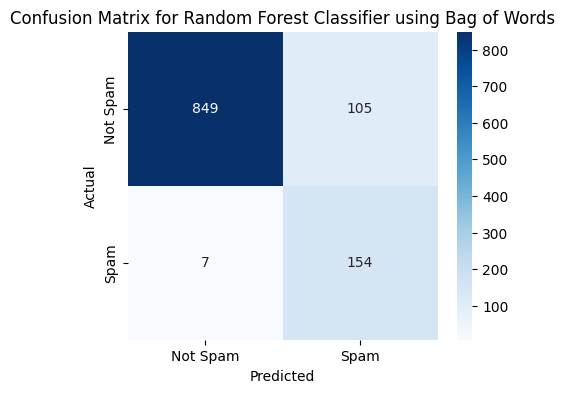

In [14]:
cm = confusion_matrix(y_test, pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier using Bag of Words")
plt.show()

**XGBOOST**

In [16]:
# XGBoost
xgb = XGBClassifier(n_estimators = 100, eval_metric='logloss')
xgb.fit(X_train_bow, y_train_resampled)
pred_xgb = xgb.predict(X_test_bow)
print("XGBoost (BoW):\n", classification_report(y_test, pred_xgb))

XGBoost (BoW):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       954
           1       0.97      0.89      0.93       161

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



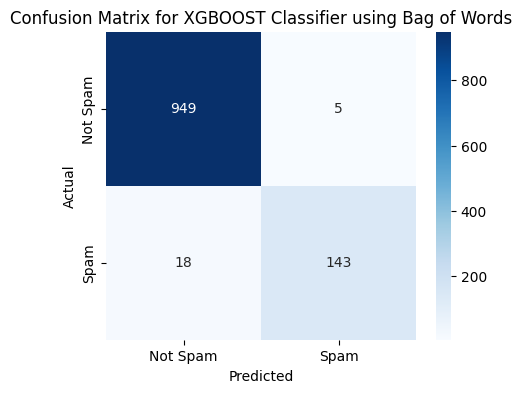

In [17]:
cm = confusion_matrix(y_test, pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBOOST Classifier using Bag of Words")
plt.show()

**LGBM**

In [22]:
X_train_bow = X_train_bow.astype(np.float32)  # Convert to float32
X_test_bow = X_test_bow.astype(np.float32)
#lgbm
lgbm_model = LGBMClassifier(boosting_type='gbdt', n_estimators= 400,objective='binary', random_state=42)
lgbm_model.fit(X_train_bow, y_train_resampled)
pred_lgbm = lgbm_model.predict(X_test_bow)
print("LGBM (BoW):\n", classification_report(y_test, pred_lgbm))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3873, number of negative: 3873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 7746, number of used features: 514
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM (BoW):
               precision    recall  f1-score   support

           0       0.99      0.89      0.93       954
           1       0.58      0.94      0.72       161

    accuracy                           0.89      1115
   macro avg       0.79      0.91      0.83      1115
weighted avg       0.93      0.89      0.90      1115



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


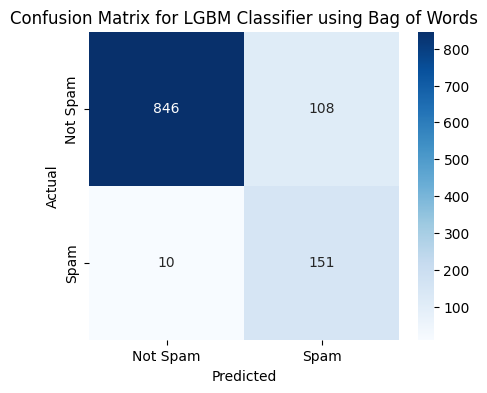

In [23]:
cm = confusion_matrix(y_test, pred_lgbm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LGBM Classifier using Bag of Words")
plt.show()

<ipython-input-35-b28da0e9191a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data = results, palette='viridis')


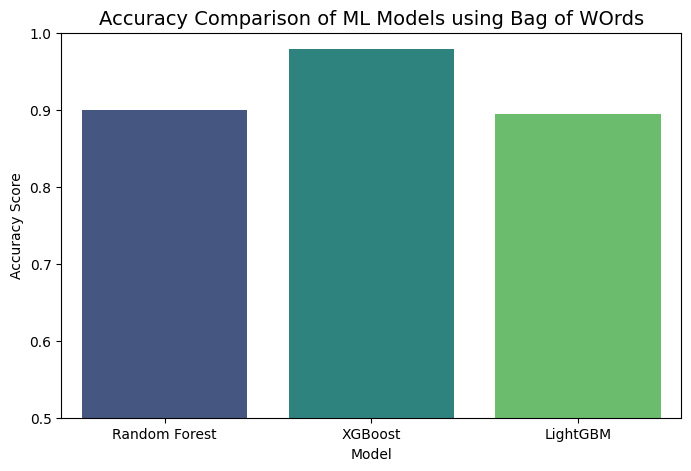

In [35]:
rf_acc = accuracy_score(y_test, pred_rf)
xgb_acc = accuracy_score(y_test, pred_xgb)
lgbm_acc = accuracy_score(y_test, pred_lgbm)
# Store accuracy results
accuracy_results = {
    'Random Forest': rf_acc,
    'XGBoost': xgb_acc,
    'LightGBM': lgbm_acc
}
results = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data = results, palette='viridis')
plt.title('Accuracy Comparison of ML Models using Bag of WOrds', fontsize=14)
plt.ylabel('Accuracy Score')
plt.ylim(0.5, 1.0)  # Adjust based on expected accuracy range
plt.show()

**TF-IDF**

In [24]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_tfidf, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tfidf, y_train_resampled)
pred_rf_tfidf = rf.predict(X_test_tfidf)
print("Random Forest (TF-IDF):\n", classification_report(y_test, pred_rf_tfidf))

Random Forest (TF-IDF):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       1.00      0.88      0.94       161

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



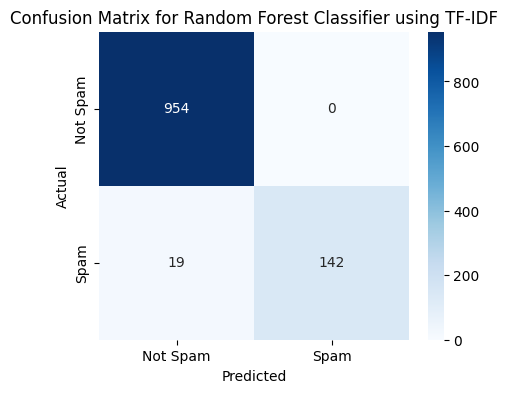

In [27]:
cm = confusion_matrix(y_test, pred_rf_tfidf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier using TF-IDF")
plt.show()

**XGBOOST**

In [29]:
# XGBoost
xgb = XGBClassifier(n_estimators = 100, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train_resampled)
pred_xg_tfidf = rf.predict(X_test_tfidf)
print("XGBoost (TF-IDF):\n", classification_report(y_test, pred_xg_tfidf))

XGBoost (TF-IDF):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       1.00      0.88      0.94       161

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



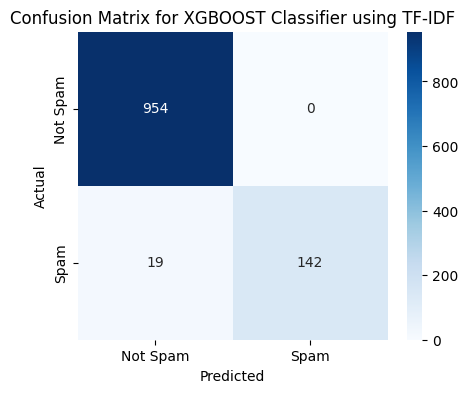

In [30]:
cm = confusion_matrix(y_test, pred_xg_tfidf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBOOST Classifier using TF-IDF")
plt.show()

**LGBM**

In [32]:
X_train_tfidf = X_train_tfidf.astype(np.float32)  # Convert to float32
X_test_tfidf = X_test_tfidf.astype(np.float32)
#lgbm
lgbm_model = LGBMClassifier(boosting_type='gbdt', n_estimators= 100,objective='binary', random_state=42)
lgbm_model.fit(X_train_tfidf, y_train_resampled)
pred_lgbm_tfidf = lgbm_model.predict(X_test_tfidf)
print("LGBM (BoW):\n", classification_report(y_test, pred_lgbm_tfidf))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3873, number of negative: 3873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26866
[LightGBM] [Info] Number of data points in the train set: 7746, number of used features: 906
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM (BoW):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       954
           1       0.97      0.91      0.94       161

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


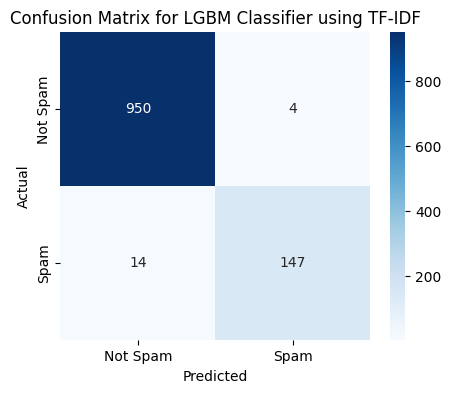

In [33]:
cm = confusion_matrix(y_test, pred_lgbm_tfidf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LGBM Classifier using TF-IDF")
plt.show()

<ipython-input-34-2aef603e36ce>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data = results, palette='viridis')


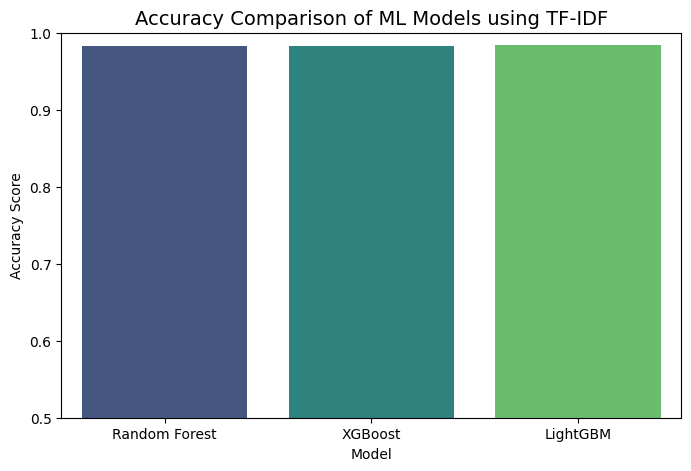

In [34]:
rf_acc = accuracy_score(y_test, pred_rf_tfidf)
xgb_acc = accuracy_score(y_test, pred_xg_tfidf)
lgbm_acc = accuracy_score(y_test, pred_lgbm_tfidf)
# Store accuracy results
accuracy_results = {
    'Random Forest': rf_acc,
    'XGBoost': xgb_acc,
    'LightGBM': lgbm_acc
}
results = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data = results, palette='viridis')
plt.title('Accuracy Comparison of ML Models using TF-IDF', fontsize=14)
plt.ylabel('Accuracy Score')
plt.ylim(0.5, 1.0)  # Adjust based on expected accuracy range
plt.show()

In [38]:
# Tokenization
max_words = 5000  # Vocabulary size
max_len = 100     # Max length of a comment

tokenizer = Tokenizer(num_words=max_words, oov_token="")
tokenizer.fit_on_texts(df['clean_sms'])
sequences = tokenizer.texts_to_sequences(df['clean_sms'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

In [39]:
# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (positive/negative)
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,201 (2.12 MB)

 Trainable params: 555,201 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 30, batch_size= 128)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.8746 - loss: 0.3779 - val_accuracy: 0.8556 - val_loss: 0.4130
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.8677 - loss: 0.3913 - val_accuracy: 0.8556 - val_loss: 0.4140
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.8599 - loss: 0.4059 - val_accuracy: 0.8556 - val_loss: 0.4142
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 326ms/step - accuracy: 0.8699 - loss: 0.3871 - val_accuracy: 0.8556 - val_loss: 0.4132
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.8664 - loss: 0.3936 - val_accuracy: 0.8556 - val_loss: 0.4139
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.8616 - loss: 0.4026 - val_accuracy: 0.8556 - val_loss: 0.4144
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.8634 - loss: 0.3996 - val_accuracy: 0.8556 - val_loss: 0.4138
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.8662 - loss: 0.3937 - val_accu

In [42]:
y_pred_ann = model.predict(X_test)
y_pred_ann = np.where(y_pred_ann > 0.5, 1, 0)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


In [43]:
print(classification_report(y_test, y_pred_ann))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       954
           1       0.00      0.00      0.00       161

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.73      0.86      0.79      1115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


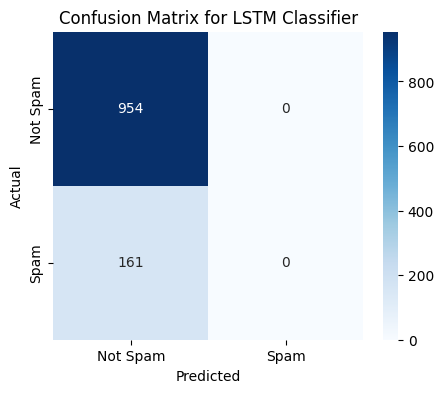

In [44]:
cm = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LSTM Classifier")
plt.show()

**Bi-LSTM**

In [45]:
model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    Bidirectional(LSTM(units=128, return_sequences=False)),
                    Dense(1, activation='sigmoid')])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 734,753 (2.80 MB)

 Trainable params: 734,753 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 128)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 792ms/step - accuracy: 0.7933 - loss: 0.4177 - val_accuracy: 0.9318 - val_loss: 0.1958
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9653 - loss: 0.1202 - val_accuracy: 0.9794 - val_loss: 0.0627
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 760ms/step - accuracy: 0.9870 - loss: 0.0464 - val_accuracy: 0.9892 - val_loss: 0.0479
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 709ms/step - accuracy: 0.9949 - loss: 0.0213 - val_accuracy: 0.9901 - val_loss: 0.0375
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 741ms/step - accuracy: 0.9977 - loss: 0.0126 - val_accuracy: 0.9901 - val_loss: 0.0425
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.9979 - loss: 0.0096 - val_accuracy: 0.9874 - val_loss: 0.0432
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 764ms/step - accuracy: 0.9988 - loss: 0.0042 - val_accuracy: 0.9839 - val_loss: 0.0477
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 773ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accurac

In [47]:
y_pred_bi_lstm = model.predict(X_test)
y_pred_bi_lstm  = np.where(y_pred_bi_lstm  > 0.5, 1, 0)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step


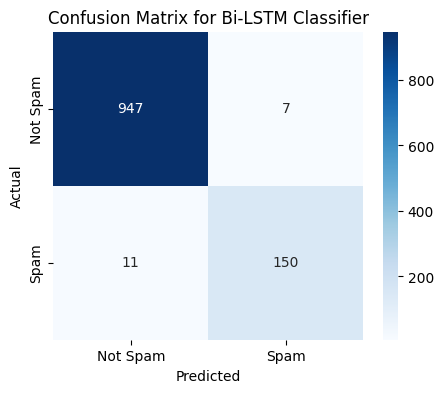

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       954
           1       0.96      0.93      0.94       161

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [48]:
cm = confusion_matrix(y_test, y_pred_bi_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Bi-LSTM Classifier")
plt.show()
print(classification_report(y_test, y_pred_bi_lstm))

In [54]:
rf_acc = accuracy_score(y_test, pred_rf_tfidf)
xgb_acc = accuracy_score(y_test, pred_xg_tfidf)
lgbm_acc = accuracy_score(y_test, pred_lgbm_tfidf)
lstm_acc = accuracy_score(y_test, y_pred_ann)
bi_lstm_acc = accuracy_score(y_test, y_pred_bi_lstm)

<ipython-input-58-e59f7d07fe5c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette="viridis")


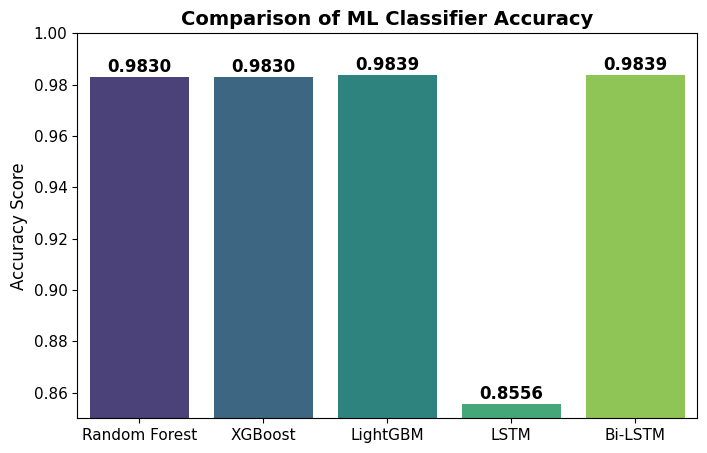

In [58]:
accuracy_results = {
    'Random Forest': round(rf_acc, 4),
    'XGBoost': round(xgb_acc, 4),
    'LightGBM': round(lgbm_acc, 4),
    'LSTM': round(lstm_acc, 4),
    'Bi-LSTM': round(bi_lstm_acc, 4)
}

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette="viridis")

# Add values on top of the bars
for i, value in enumerate(accuracy_results.values()):
    plt.text(i, value + 0.002, f"{value:.4f}", ha='center', fontsize=12, fontweight='bold')

# Formatting the plot
plt.title("Comparison of ML Classifier Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy Score", fontsize=12)
plt.ylim(0.85, 1.0)  # Adjusting the y-axis range for better visibility
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show the plot
plt.show()
